In [23]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os


In [24]:
# Define dataset path
data_dir = "./data"

# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load dataset
batch_size = 512
img_size = (160, 160)


# The Data

The dataset used in this project is available at the following link:  
[Microsoft DigiFace-1M Dataset](https://github.com/microsoft/DigiFace1M)

> The DigiFace-1M dataset is a collection of over one million diverse synthetic face images for face recognition.  
> The DigiFace-1M dataset can be used for non-commercial research.  
>   
> The dataset contains:  
>   
> - 720K images with 10K identities (72 images per identity). For each identity, 4 different sets of accessories are sampled and 18 images are rendered for each set.  
> - 500K images with 100K identities (5 images per identity). For each identity, only one set of accessories is sampled.

From the dataset, I am using 32 folders, each representing a class of 3D-rendered synthetic people. Each folder includes 71 photos captured from different angles and lighting conditions.

## Batch Size

Batch size refers to the number of images processed by the model at once. In this case, 32 images are passed through the neural network per batch.

- **Larger Batch Size**: Speeds up training but requires more memory.
- **Smaller Batch Size**: Provides better generalization but slows down training.

I tried 32, 64 and 128 in my testing 128 seemed to preform best for me

## Image Size

Images are resized to 160x160 pixels before being fed into the neural network. This ensures that all input images have the same dimensions for consistency.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.6, 1.4),
    fill_mode='nearest'
)

train_dataset = datagen.flow_from_directory(
    "data",
    target_size=(160, 160),
    batch_size=32,
    class_mode="sparse",
    subset="training",
    seed=123
)

val_dataset = datagen.flow_from_directory(
    "data",
    target_size=(160, 160),
    batch_size=32,
    class_mode="sparse",
    subset="validation",
    seed=123
)

# Get class names
class_names = list(train_dataset.class_indices.keys())
print("Class names:", class_names)

# Ensure the number of classes matches the dataset
num_classes = len(class_names)
print("Number of classes:", num_classes)


Found 5813 images belonging to 101 classes.
Found 1403 images belonging to 101 classes.
Class names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'me']
Number of classes: 101


In [ ]:
# Convert DirectoryIterator to tf.data.Dataset
train_dataset_eff = tf.data.Dataset.from_generator(
	lambda: train_dataset,
	output_signature=(
		tf.TensorSpec(shape=(160, 160, 3), dtype=tf.float32),
		tf.TensorSpec(shape=(), dtype=tf.int32)
	)
)

val_dataset_eff = tf.data.Dataset.from_generator(
	lambda: val_dataset,
	output_signature=(
		tf.TensorSpec(shape=(160, 160, 3), dtype=tf.float32),
		tf.TensorSpec(shape=(), dtype=tf.int32)
	)
)

In [41]:

# Create model
model = models.Sequential([
    # Convolutional base
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Regularisation
    layers.Dropout(0.3),

    # Dense head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])



In [42]:

# Compile model
model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     1,327,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 101)            │         6,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,390,053 (5.30 MB)

 Trainable params: 1,390,053 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
callbacks = [
    # Stop training when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    
    # Save best model
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


In [44]:
# Train the model with a large number of max epochs
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.0117 - loss: 4.6183
Epoch 1: val_accuracy improved from -inf to 0.00998, saving model to best_model.h5


182/182 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.0117 - loss: 4.6183 - val_accuracy: 0.0100 - val_loss: 4.6135 - learning_rate: 0.0010
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.0069 - loss: 4.6142
Epoch 2: val_accuracy improved from 0.00998 to 0.01212, saving model to best_model.h5


182/182 ━━━━━━━━━━━━━━━━━━━━ 43s 237ms/step - accuracy: 0.0069 - loss: 4.6142 - val_accuracy: 0.0121 - val_loss: 4.6122 - learning_rate: 0.0010
Epoch 3/20


KeyboardInterrupt: 

In [ ]:
# Save the model
model.save('model.h5')
print("Model saved to disk.")

Model saved to disk.


In [ ]:
# Evaluating the model

test_loss, test_acc = model.evaluate(val_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.0839 - loss: 4.0561
Test Accuracy: 0.0827


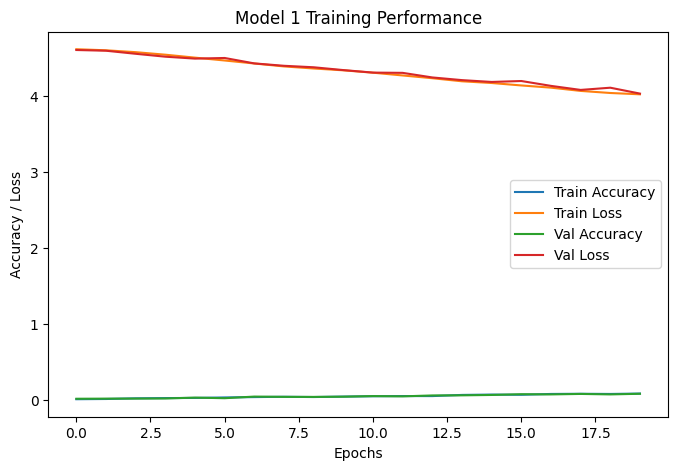

In [ ]:
# Plotting the training performance
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.title('Model 1 Training Performance')
plt.show()
